In [ ]:
import spacy 
import re 
import pandas as pd
from spacy.lang.en import English
from collections import Counter
from itertools import chain
import ahocorasick
import ast
from clean_data import get_occupations_list_en, get_occupations_list
from spacy.lang.de import German
from spacy.lang.it import Italian
from spacy.lang.es import Spanish 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from operator import itemgetter

/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/my_venv/lib64/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def stem_titles(titles):
  from nltk.stem import SnowballStemmer 
  stemmer = SnowballStemmer("spanish") # Choose a language
  stems = []
  for title in titles:
     stem = stemmer.stem(title)
     stems.append(stem)
  return stems
es_occ_titles = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/es_occ_list_from_en.csv', encoding='utf-8')
es_occ_list = es_occ_titles['occupations'].to_list()
es_occ_list = [x for x in es_occ_list if pd.notnull(x)]
stems = stem_titles(es_occ_list)
print(stems[:10])

['abstractor', 'contabl', 'acrobat', 'actor', 'actriz', 'actuari', 'acupresor', 'acupuntor', 'direccion', 'adjud']


In [3]:
def get_occupations(df):
    new_df = df
    # print(unique_gender_counts)
    # number of biographies that returned no intro 
    print("num intros unavailable")
    print((new_df['intro'] == 'No intro available').sum())
    # remove biographies with no intro 
    new_df = new_df[new_df.intro != 'No intro available']
    print(new_df.shape[0])
    small_df = new_df.copy()
    # lowercase intro strings
    small_df['intro'] = small_df['intro'].str.casefold()
    small_df['title'] = small_df['title'].str.casefold()
    # small_df['first_sentence'] = small_df['first_sentence'].str.casefold()
    # the lists in the occupations column were not actual lists but rather string literals
    # this code converts them back into lists  
    # small_df['occupations'] = small_df['occupations'].apply(ast.literal_eval)

    # get a set of occupation words 
    full_unique_occupations = set(stem_titles(es_occ_list))
    # full_unique_occupations = get_occupations_list('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/de_occ_titles.csv', gender)
    # full_unique_occupations = get_occupations_list_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/it_occ_list_full.csv')
    # full_unique_occupations = get_occupations_list_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/es_occ_list_unique.csv')
    small_df['intro'] = small_df['intro'].astype(str)
    small_df['title'] = small_df['title'].astype(str)
    
    # want to find overlapping terms in the intros column and the wikidata occupation words set 
    automaton = ahocorasick.Automaton()
    for id, term in enumerate(full_unique_occupations):
        automaton.add_word(term, (term))
    automaton.remove_word('-')
    automaton.make_automaton()
    def find_terms_en(text):
        return list(term for _, term in automaton.iter(text))
    def find_terms_de(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches
    def find_terms_stems1(text):
      matching_tokens = []
      substrings = list(full_unique_occupations)
      tokens = text.split()
      for token in tokens:
        if any(sub in token for sub in substrings):
          matching_tokens.append(token)
      return matching_tokens
    
    def find_terms_stems(text):
      # ner = spacy.load('en_core_web_sm') 
      # ner = spacy.load('de_core_news_sm')
    #   ner = spacy.load('it_core_news_sm') 
      ner = spacy.load('es_core_news_sm')
      doc = ner(text) 
      occupational_titles = list(full_unique_occupations)
      matched_occupations = []
      for ent in doc: 
        if any(sub in ent.text.casefold() for sub in occupational_titles):
          if not ent.ent_type_:
              # matched_occupations.append(ent.text)
              matched_occupations.append({ent.text: ent.morph.get("Gender")})
        # print(ent.text, ent.pos_, ent.dep_)
          # print(ent,ent.morph.get("Gender"))
      return (matched_occupations)
    
    # small_df['overlapping_occupations'] = small_df['intro'].apply(find_terms_stems)
    # small_df['overlapping_occupations_sentence1'] = small_df['first_sentence'].apply(find_terms_stems)
    # want to see if male occupation names show up in title field as last names 
    # small_df['occupation_in_last_name'] = small_df['title'].apply(find_terms_stems)
    small_df['overlapping_occupations_sentence1'] = small_df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    occ_counts_counter = Counter(
    key
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for key in d.keys()
    )

    occ_gender_counts_counter = Counter(
    value
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for values in d.values()
    for value in values
    )
   
    # overlapping_occ_counts = Counter(chain.from_iterable([small_df['overlapping_occupations_sentence1'].keys()]))
    # print(small_df[['wikidata_code','intro', 'overlapping_occupations']].head(20))
    print(occ_counts_counter)
    print(occ_gender_counts_counter)
    smaller_df = small_df[small_df['overlapping_occupations_sentence1'].map(len)>0]
    # smaller_df = smaller_df[smaller_df['overlapping_occupations'].map(len)>0]

    print("length of dataset:")
    print(small_df.shape[0])
    print("first sentences with occ title found:", smaller_df.shape[0])
    return occ_counts_counter
    

In [6]:
es_female_df_redo = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/redo/es_female_occ_decoded.csv', encoding='utf-8')
female_occ_counts_redo = get_occupations(es_female_df_redo)

num intros unavailable
0
68522
Counter({'actriz': 17389, 'cantante': 6954, 'deportista': 5879, 'escritora': 5417, 'modelo': 3973, 'politica': 3814, 'periodista': 2202, 'profesora': 2150, 'especialista': 2149, 'compositora': 1955, 'directora': 1734, 'presentadora': 1581, 'esposa': 1549, 'hija': 1543, 'activista': 1445, 'consiguio': 1422, 'artista': 1409, 'campeona': 1329, 'para': 1294, 'botanica': 1199, 'bailarina': 1154, 'reina': 1146, 'mujer': 1145, 'poeta': 1101, 'princesa': 1045, 'productora': 1038, 'musica': 999, 'subcampeona': 985, 'cinematografica': 943, 'pintora': 933, 'abogada': 899, 'artistico': 897, 'artistica': 781, 'guionista': 761, 'artisticamente': 748, 'investigadora': 700, 'principalmente': 696, 'empresaria': 681, 'poetisa': 656, 'autora': 650, 'piraguismo': 647, 'matrimonio': 644, 'futbolista': 586, 'historiadora': 586, 'interpretado': 543, 'traductora': 528, 'segunda': 523, 'polaca': 517, 'mujeres': 510, 'interpretar': 509, 'arquitecta': 500, 'duquesa': 490, 'cantauto

In [7]:
es_male_df_redo = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/redo/es_male_occ_decoded.csv', encoding='utf-8')
male_occ_counts_redo = get_occupations(es_male_df_redo)

num intros unavailable
0
70234
Counter({'politico': 6916, 'futbolista': 5885, 'actor': 4502, 'escritor': 4223, 'exfutbolista': 4013, 'deportista': 2934, 'director': 2749, 'compositor': 2298, 'baloncesto': 1982, 'pintor': 1934, 'periodista': 1916, 'abogado': 1826, 'profesor': 1758, 'cantante': 1746, 'poeta': 1739, 'entrenador': 1671, 'para': 1504, 'botanico': 1453, 'musico': 1437, 'productor': 1357, 'especialista': 1320, 'historiador': 1293, 'futbol': 1133, 'empresario': 1099, 'centrocampista': 1014, 'medico': 1013, 'guionista': 983, 'hijo': 948, 'presidente': 944, 'ingeniero': 919, 'diplomatico': 897, 'escultor': 897, 'arquitecto': 782, 'autor': 736, 'artista': 726, 'artistico': 719, 'campeon': 643, 'musica': 628, 'banda': 603, 'critico': 586, 'guitarrista': 581, 'dramaturgo': 573, 'ministro': 567, 'economista': 558, 'parte': 541, 'piraguismo': 537, 'considerado': 536, 'consiguio': 525, 'cinematografico': 489, 'polaco': 489, 'principalmente': 472, 'subcampeon': 471, 'participo': 470, '

In [8]:
def get_occ_gender_counts(df):
    result = {}
    df['overlapping_occupations_sentence1'] = df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    # Define the expected gender categories
    genders = ['Fem', 'Masc', 'Neutral']
    occupation_list = df['overlapping_occupations_sentence1'].tolist()
    # Loop through each item in the list
    for items in occupation_list :
        for item in items:
            for profession, gender_list in item.items():
                # Ensure the profession is in the result dictionary
                if profession not in result:
                    result[profession] = {g: 0 for g in genders}

                if not gender_list:
                    result[profession]['Neutral'] += 1
                else:
                    # Increment the corresponding gender count
                    for gender in gender_list:
                        if gender in result[profession]:
                            result[profession][gender] += 1
    # print(result)
    return result

In [9]:
occupation_genders = get_occ_gender_counts(es_female_df_redo)

In [10]:
occupation_genders_male = get_occ_gender_counts(es_male_df_redo)

In [17]:
female_occ_counts_dict = dict(sorted(female_occ_counts_redo.items(), key=itemgetter(1), reverse=True))
print(female_occ_counts_dict['presidente'])
print(female_occ_counts_dict['presidenta'])
print(female_occ_counts_dict['vicepresidente'])
print(female_occ_counts_dict['vicepresidenta'])

264
241
12
49


In [12]:
male_occ_counts_dict = dict(sorted(male_occ_counts_redo.items(), key=itemgetter(1), reverse=True))
print(male_occ_counts_dict['presidente'])
print(male_occ_counts_dict['presidenta'])
print(male_occ_counts_dict['vicepresidente'])


944
1
75


In [ ]:

summary_df = pd.DataFrame(occupation_genders).T.fillna(0).astype(int)
# step 1: add a total column
summary_df['Total'] = summary_df.sum(axis=1)

# step 2: calculate male percentage
summary_df['Male_Percentage'] = summary_df['Masc'] / summary_df['Total']

# step 3: sort by male percentage (descending)
sorted_by_male = summary_df.sort_values(by='Masc', ascending=False)


print(sorted_by_male[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

             Fem  Masc  Total  Male_Percentage
modelo      2223  1749   3973         0.440221
poeta         91  1006   1101         0.913715
artistico      0   897    897         1.000000
piraguismo     0   647    647         1.000000
baloncesto     0   485    485         1.000000
presidente     0   264    264         1.000000
logrado        0   231    231         1.000000
varios         0   214    214         1.000000
periodo        0   191    191         1.000000
represento     0   147    158         0.930380
exmodelo       2   144    148         0.972973
acrobatico     0   140    140         1.000000
futbol         0   129    138         0.934783
conseguido     0   128    128         1.000000
hijo           0   126    126         1.000000
hijos          0   122    122         1.000000
musico         0   107    107         1.000000
esposo         0   104    104         1.000000
politico       0   100    100         1.000000
antiguo        0    93     93         1.000000
murio        

In [12]:
sorted_by_female = summary_df.sort_values(by='Fem', ascending=False)


print(sorted_by_female[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

                Fem  Masc  Total  Male_Percentage
actriz         2032     0   2036          0.00000
escritora       815     0    815          0.00000
profesora       413     0    422          0.00000
presentadora    364     0    364          0.00000
directora       294     0    294          0.00000
modelo          282   184    466          0.39485
abogada         261     0    261          0.00000
investigadora   236     0    236          0.00000
compositora     183     0    187          0.00000
pintora         163     0    163          0.00000
historiadora    161     0    161          0.00000
bailarina       149     0    181          0.00000
mujer           145     0    145          0.00000
empresaria      140     0    141          0.00000
productora      133     0    133          0.00000
locutora        126     0    126          0.00000
poetisa         121     0    121          0.00000
hija            111     0    111          0.00000
conductora      106     0    106          0.00000


In [ ]:
def make_plot(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:30])
    print(ten_items, len(ten_items))
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), averages, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Percentage of Occupational Title Occurences in Spanish Female Data")
    plt.show()

{'actriz': 17389, 'cantante': 6954, 'deportista': 5879, 'escritora': 5417, 'modelo': 3973, 'politica': 3814, 'periodista': 2202, 'profesora': 2150, 'especialista': 2149, 'compositora': 1955, 'directora': 1734, 'presentadora': 1581, 'activista': 1445, 'artista': 1409, 'campeona': 1329, 'botanica': 1199, 'bailarina': 1154, 'reina': 1146, 'poeta': 1101, 'princesa': 1045, 'productora': 1038, 'musica': 999, 'subcampeona': 985, 'cinematografica': 943, 'pintora': 933, 'abogada': 899, 'guionista': 761, 'investigadora': 700, 'empresaria': 681, 'autora': 650} 30
73614.0
[0.23621865406036896, 0.09446572662808705, 0.07986252614991714, 0.07358654603743853, 0.05397071209280843, 0.051810796859293066, 0.029912788328307117, 0.029206400956339827, 0.029192816583801993, 0.026557448311462492]


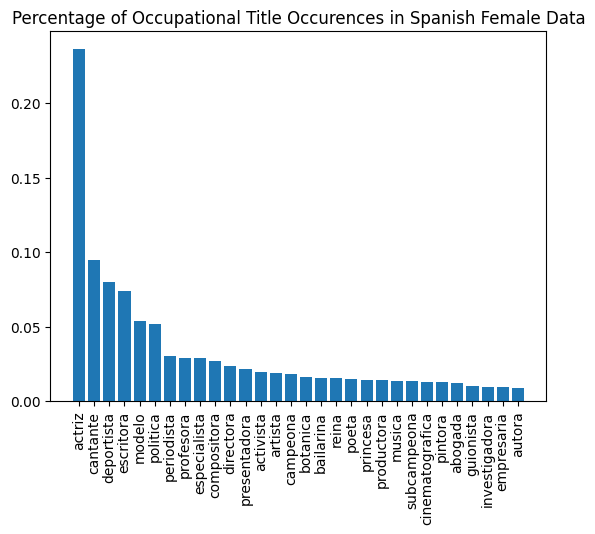

In [29]:
make_plot(female_occ_counts_redo)

{'actriz': 2035, 'escritora': 815, 'politica': 782, 'deportista': 709, 'cantante': 576, 'periodista': 573, 'modelo': 466, 'profesora': 422, 'presentadora': 364, 'artista': 336, 'directora': 294, 'poeta': 265, 'abogada': 261, 'investigadora': 236, 'activista': 223, 'compositora': 187, 'bailarina': 180, 'pintora': 163, 'historiadora': 161, 'empresaria': 141, 'productora': 133, 'guionista': 127, 'locutora': 125, 'poetisa': 121, 'especialista': 117, 'conductora': 106, 'esposa': 100, 'maestra': 94, 'traductora': 89, 'educadora': 89, 'dramaturga': 86}
10376.0
[0.19612567463377023, 0.07854664610639939, 0.07536622976098689, 0.0683307632999229, 0.05551272166538165, 0.05522359290670779, 0.044911333847340015, 0.04067077872012336, 0.03508095605242868, 0.03238242097147263]


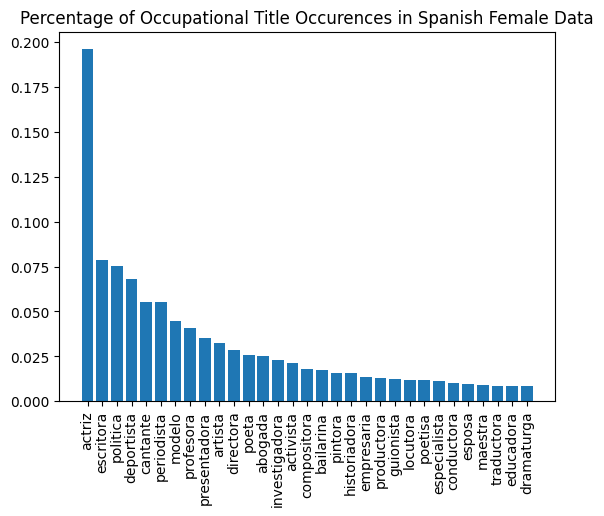

In [45]:
make_plot(female_occ_counts)

{'politico': 1468, 'futbolista': 730, 'escritor': 644, 'abogado': 552, 'periodista': 514, 'actor': 427, 'profesor': 345, 'exfutbolista': 321, 'director': 316, 'poeta': 313, 'botanico': 284, 'deportista': 260, 'empresario': 246, 'compositor': 240, 'historiador': 236, 'pintor': 219, 'medico': 218, 'ingeniero': 204, 'diplomatico': 182, 'musico': 173, 'cantante': 154, 'productor': 132, 'arquitecto': 125, 'entrenador': 122, 'presidente': 119, 'guionista': 114, 'investigador': 112, 'economista': 108, 'baloncesto': 107, 'critico': 97}
9082.0
[0.16163840563752477, 0.08037877119577186, 0.07090949130147545, 0.06077956397269324, 0.056595463554283194, 0.047016075754239155, 0.037987227482933275, 0.03534463774499009, 0.03479409821625193, 0.03446377449900903]


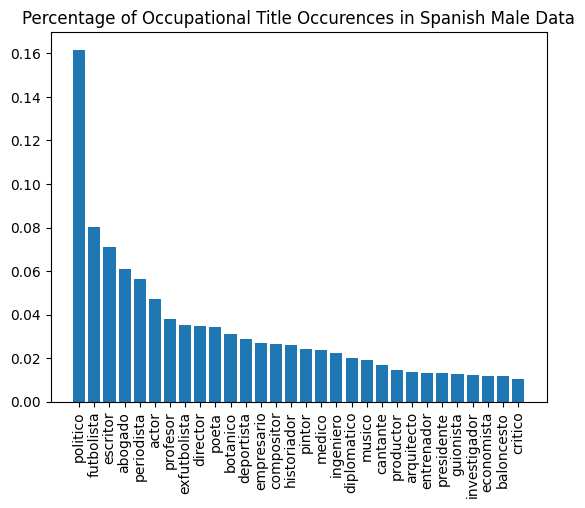

In [54]:
make_plot(male_occ_counts)

{'politico': 6916, 'futbolista': 5885, 'actor': 4502, 'escritor': 4223, 'exfutbolista': 4013, 'deportista': 2934, 'director': 2749, 'compositor': 2298, 'pintor': 1934, 'periodista': 1916, 'abogado': 1826, 'profesor': 1758, 'cantante': 1746, 'poeta': 1739, 'entrenador': 1671, 'botanico': 1453, 'musico': 1437, 'productor': 1357, 'especialista': 1320, 'historiador': 1293, 'empresario': 1099, 'centrocampista': 1014, 'medico': 1013, 'guionista': 983, 'presidente': 944, 'ingeniero': 919, 'escultor': 897, 'arquitecto': 782, 'autor': 736, 'artista': 726} 30
62083.0
[0.11139925583493065, 0.09479245526150476, 0.07251582558832531, 0.06802184172800928, 0.06463927323099722, 0.047259314143968556, 0.044279432372791264, 0.03701496383873202, 0.031151845110577774, 0.03086191066797674]


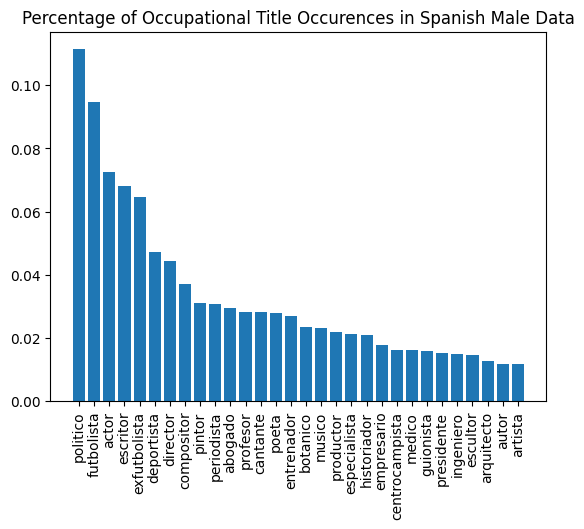

In [17]:
make_plot(male_occ_counts_redo)